# Care Centers in Castellon – Analysis Template

This notebook demonstrates how to use the modularized code for data loading, cleaning, mapping, and analysis of care centeres in Castellon

In [21]:
# --- 1. Notebook Setup: Import paths, libraries, and modules ---
import sys
import os
print("Current working directory:", os.getcwd())    # Print the current working directory

# Go up one directory from notebooks (your working directory) to ensure compatibility with linux, MacOS and other systems.
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print("Repo root (src) added to sys.path:", repo_root)

# Then join with 'src' to get the full path to src
src_path = os.path.join(repo_root, 'src')

# Add the path to the src directory
sys.path.append(src_path)  # Ensure the src folder is in the path

# Add src to sys.path if it's not already there
if repo_root not in sys.path:
    sys.path.append(repo_root)

# Print the current sys.path for debugging
'''
print("\nCurrent sys.path:") 
for path in sys.path:
    print(path)   
''' 

# Import necessary libraries and your custom modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from data import fetch_osm_data, clean_data
from src.mapping import generate_castellon_map
from src.visualization import display_images
import src.config   as config

Current working directory: c:\Documents\GitHub\Repo\care-centers-castellon\notebooks
Repo root (src) added to sys.path: c:\Documents\GitHub\Repo\care-centers-castellon


## 2. Data Collection

Use the data module to fetch OSM data for Castellón.

In [22]:
def fetch_osm_data(city_name, network_type='drive'):
    """
    Fetch OpenStreetMap data for the given city and network types.
    Args:
        city_name (str): Name of the city.
        network_types (str): Type of network to fetch (e.g., 'drive', 'walk').
    Returns:
        gdf_nodes, gdf_edges: Geodataframes for nodes and edges.
    """
    import osmnx as ox
    # Set the OSMnx cache directory
    graph = ox.graph_from_place(city_name, network_type=network_type)
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(graph)
    return gdf_nodes, gdf_edges

In [23]:
city_name = "Castellón, Valencian Community, Spain"
gdf_nodes, gdf_edges = fetch_osm_data(city_name)
print(f"Nodes: {gdf_nodes.shape}, Edges: {gdf_edges.shape}")

Nodes: (39947, 6), Edges: (87920, 16)


## 3. Data Inspection

Preview the raw dataframes.

In [24]:
gdf_edges.head()

osmid  oneway lanes    ref                name  \
u         v           key                                                       
241152115 241152143   0    190076918   False     2  CV-20  Carretera de Tales   
          247105272   0    190076918   False     2  CV-20  Carretera de Tales   
241152143 247105306   0     22940181   False   NaN    NaN                 NaN   
          12464799089 0    190076918   False     2  CV-20  Carretera de Tales   
          241152115   0    190076918   False     2  CV-20  Carretera de Tales   

                               highway reversed   length  \
u         v           key                                  
241152115 241152143   0        primary    False  146.441   
          247105272   0        primary     True   48.182   
241152143 247105306   0    residential     True   40.919   
          12464799089 0        primary    False  162.971   
          241152115   0        primary     True  146.441   

                                                                    geometry  \
u         v           key                                                      
241152115 241152143   0    LINESTRING (-0.52193 40.06838, -0.52215 40.068...   
          247105272   0    LINESTRING (-0.52193 40.06838, -0.52188 40.068...   
241152143 247105306   0    LINESTRING (-0.52348 40.06894, -0.52364 40.068...   
          12464799089 0    LINESTRING (-0.52348 40.06894, -0.5235 40.0689...   
          241152115   0    LINESTRING (-0.52348 40.06894, -0.52344 40.068...   

                          maxspeed bridge tunnel junction width access service  
u         v           key                                                       
241152115 241152143   0        NaN    NaN    NaN      NaN   NaN    NaN     NaN  
          247105272   0        NaN    NaN    NaN      NaN   NaN    NaN     NaN  
241152143 247105306   0        NaN    NaN    NaN      NaN   NaN    NaN     NaN  
          12464799089 0        NaN    NaN    NaN      NaN   NaN    NaN     NaN  
          241152115   0        NaN    NaN    NaN      NaN   NaN    NaN     NaN

In [25]:
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
241152115,40.068383,-0.521933,3,NaN,NaN,POINT (-0.52193 40.06838)
241152143,40.068940,-0.523476,3,NaN,NaN,POINT (-0.52348 40.06894)
241152165,40.070172,-0.524803,3,NaN,NaN,POINT (-0.5248 40.07017)
241152215,40.072179,-0.526766,3,NaN,NaN,POINT (-0.52677 40.07218)
241160500,40.009595,-0.321847,3,NaN,NaN,POINT (-0.32185 40.00959)


## 4. Data Cleaning

Clean the edge dataframe using the clean_data utility.

In [26]:
gdf_edges_clean = clean_data(gdf_edges)
gdf_edges_clean.head()

osmid  oneway                name      highway  \
u         v           key                                                       
241152115 241152143   0    190076918   False  Carretera de Tales      primary   
          247105272   0    190076918   False  Carretera de Tales      primary   
241152143 247105306   0     22940181   False                 NaN  residential   
          12464799089 0    190076918   False  Carretera de Tales      primary   
          241152115   0    190076918   False  Carretera de Tales      primary   

                          reversed   length  \
u         v           key                     
241152115 241152143   0      False  146.441   
          247105272   0       True   48.182   
241152143 247105306   0       True   40.919   
          12464799089 0      False  162.971   
          241152115   0       True  146.441   

                                                                    geometry  
u         v           key                                                     
241152115 241152143   0    LINESTRING (-0.52193 40.06838, -0.52215 40.068...  
          247105272   0    LINESTRING (-0.52193 40.06838, -0.52188 40.068...  
241152143 247105306   0    LINESTRING (-0.52348 40.06894, -0.52364 40.068...  
          12464799089 0    LINESTRING (-0.52348 40.06894, -0.5235 40.0689...  
          241152115   0    LINESTRING (-0.52348 40.06894, -0.52344 40.068...

## 5. Quick Data Summary

Check the number of columns and rows after cleaning.

In [27]:
print(f"Cleaned Edges shape: {gdf_edges_clean.shape}")
print(f"Columns: {gdf_edges_clean.columns.tolist()}")

Cleaned Edges shape: (87920, 7)
Columns: ['osmid', 'oneway', 'name', 'highway', 'reversed', 'length', 'geometry']


## 6. Interactive Map of Castellon

Use the mapping module to generate a folium map.

In [28]:
castellon_map = generate_castellon_map()
castellon_map

## 7. Display Local Images about the study area using the visualization module 
The visualization module displays the major attraction centres at the city center as a simple way of first establishing Castellon as a tourist city. This step is important, as it helps showcase the potential of Castellon as a tourist attraction center. 

That it is an attraction center means analyzing the distribution and accessibility of care centers in the area, would be of great importance to both residents (citizens and immigrants), non-residents (visitors), health practitionals, government parastatals, and city planners. 

Tourism is a vital sector in spain, contributing significantly to the economy, with around 94 million international visitors in 2024, making it the second most visited country in the world. It accounted for 12.3% of the country's GDP in 2023 ("Tourism in Spain", 2025). 

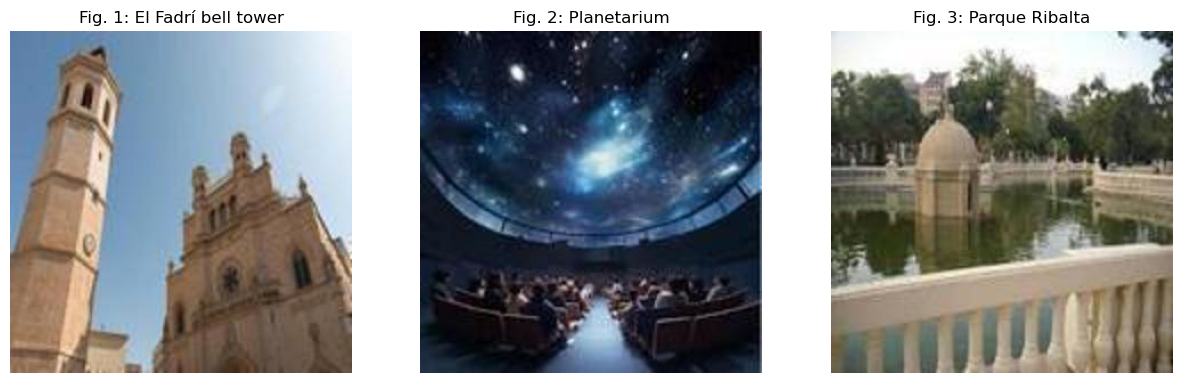

In [29]:
image_paths = [
    (config.IMAGES_PATH + "img1_El-Fadri.jpg", "Fig. 1: El Fadrí bell tower"),
    (config.IMAGES_PATH + "img2_Planetarium.jpeg", "Fig. 2: Planetarium"),
    (config.IMAGES_PATH + "img3_lush_Parque_ribalta.jpeg", "Fig. 3: Parque Ribalta"),
]
display_images(image_paths)

## 8. Further Analysis

- Continuation of spatial analysis, accessibility studies, statistical summaries, or visualizations as needed.
- Importing or implementing more functions in `src/` as the project grows.

## 8. Reference

1. Tourism in Spain. (2025, May 12). In Wikipedia. Retrieved May 17, 2025, from https://en.wikipedia.org/wiki/Tourism_in_Spain